# <center> Дипломный проект      
## <center> Прогнозирование стоимости жилья для агентства недвижимости
<img src=https://alterainvest.ru/upload/iblock/6e6/6e6f3f357a1bbc1d4cff438167d91b99.jpg>

Агентство недвижимости столкнулось с проблемой - риелторы тратят слишком много времени на сортировку объявлений и поиск выгодных предложений. Поэтому скорость их реакции и качество анализа не дотягивают до уровня конкурентов. Это сказывается на финансовых показателях агентства.  

**Бизнес-задача:** найти закономерности и выделить наиболее значимые факторы, влияющие на стоимость недвижимости, что поможет обрабатывать объявления, увеличит число и качество совершения сделок, а также повысит прибыль агентства. 

**Техническая задача:** разработать модель регрессии, которая прогнозирует стоимость недвижимости.

# 1. Исследование структуры данных

In [1]:
# импорт библиотек
import numpy as np
import pandas as pd
import re

# визуализация
import matplotlib.pyplot as plt
import seaborn as sns

Прочитаем файл с исходными данными:

In [2]:
data = pd.read_csv("data/data.csv")
print('Data shape: {}'.format(data.shape))
data.head()

Data shape: (377185, 18)


,status,private pool,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,mls-id,PrivatePool,MlsId,target
0,Active,NaN,Single Family Home,240 Heather Ln,3.5,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",Gas Logs,Southern Pines,"[{'rating': ['4', '4', '7', 'NR', '4', '7', 'N...",2900,28387,4,NC,NaN,NaN,NaN,611019,"$418,000"
1,for sale,NaN,single-family home,12911 E Heroy Ave,3 Baths,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",NaN,Spokane Valley,"[{'rating': ['4/10', 'None/10', '4/10'], 'data...","1,947 sqft",99216,3 Beds,WA,2.0,NaN,NaN,201916904,"$310,000"
2,for sale,NaN,single-family home,2005 Westridge Rd,2 Baths,"{'atAGlanceFacts': [{'factValue': '1961', 'fac...",yes,Los Angeles,"[{'rating': ['8/10', '4/10', '8/10'], 'data': ...","3,000 sqft",90049,3 Beds,CA,1.0,NaN,yes,FR19221027,"$2,895,000"
3,for sale,NaN,single-family home,4311 Livingston Ave,8 Baths,"{'atAGlanceFacts': [{'factValue': '2006', 'fac...",yes,Dallas,"[{'rating': ['9/10', '9/10', '10/10', '9/10'],...","6,457 sqft",75205,5 Beds,TX,3.0,NaN,NaN,14191809,"$2,395,000"
4,for sale,NaN,lot/land,1524 Kiscoe St,NaN,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",NaN,Palm Bay,"[{'rating': ['4/10', '5/10', '5/10'], 'data': ...",NaN,32908,NaN,FL,NaN,NaN,NaN,861745,"$5,000"


В нашем распоряжении более 377 тыс. наблюдений, описываемых 18 признаками. Для более удобного восприятия условно поделим их по категориям и изучим более детально:  

**Описание объекта недвижимости**  


`status` — статус продажи;  
`private pool` и `PrivatePool` — наличие собственного бассейна;  
`propertyType` — тип объекта недвижимости;  
`baths` — количество ванных комнат;  
`homeFacts` — сведения о строительстве объекта (содержит несколько типов сведений, влияющих на оценку объекта);    
`fireplace` — наличие камина;  
`sqft` — площадь в футах;  
`beds` — количество спален;  
`stories` — количество этажей;  
`mls-id` и `MlsId` — идентификатор MLS (Multiple Listing Service, система мультилистинга);

**Географическая информация**  

`street` — адрес объекта;  
`city` — город;  
`schools` — сведения о школах в районе;    
`zipcode` — почтовый индекс;    
`state` — штат;  

**Целевой фактор**
  
`target` — цена объекта недвижимости (его и будем прогнозировать).

Изучим признаки на предмет явных пропусков в данных:

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 377185 entries, 0 to 377184
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   status        337267 non-null  object
 1   private pool  4181 non-null    object
 2   propertyType  342452 non-null  object
 3   street        377183 non-null  object
 4   baths         270847 non-null  object
 5   homeFacts     377185 non-null  object
 6   fireplace     103115 non-null  object
 7   city          377151 non-null  object
 8   schools       377185 non-null  object
 9   sqft          336608 non-null  object
 10  zipcode       377185 non-null  object
 11  beds          285903 non-null  object
 12  state         377185 non-null  object
 13  stories       226470 non-null  object
 14  mls-id        24942 non-null   object
 15  PrivatePool   40311 non-null   object
 16  MlsId         310305 non-null  object
 17  target        374704 non-null  object
dtypes: object(18)
memory usa

Все признаки представлены строковым типом данных, а значит нам потребуется уделять повышенное внимание числовым значениям на этапе преобразования данных. Кроме того невооруженным глазом заметно, что лишь в нескольких факторах имеется полный набор наблюдений. Остальные признаки в большей или меньшей степени не заполнены. Чуть позже мы изучим данные также на предмет скрытых пропусков, а пока что попробуем проинтерпретировать описательные характеристики нашего датасета и сформируем первоначальное мнение о значениях, с которыми будем работать: 

In [4]:
data.describe()

,status,private pool,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,mls-id,PrivatePool,MlsId,target
count,337267,4181,342452,377183,270847,377185,103115,377151,377185,336608,377185,285903,377185,226470,24942,40311,310305,374704
unique,159,1,1280,337076,229,321009,1653,2026,297365,25405,4549,1184,39,348,24907,2,232944,43939
top,for sale,Yes,single-family home,Address Not Disclosed,2 Baths,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",yes,Houston,"[{'rating': [], 'data': {'Distance': [], 'Grad...",0,32137,3 Beds,FL,1.0,No MLS#,yes,NO MLS,"$225,000"
freq,156104,4181,92206,672,52466,7174,50356,24442,4204,11854,2141,53459,115449,67454,3,28793,24,1462


Согласно описательным характеристикам, **агентство недвижимости специализируется на продаже отдельных одноэтажных домов для семьи в американском стиле**, с личным бассейном и несколькими спальнями. При этом данные надежно защищены и не размещены в открытом доступе - об этом свидетельствует признак `street`, по которому сложно идентифицировать точное местонахождение объекта. Согласно признакам `city` и `state`, **большинство исследуемых объектов недвижимости находится на юге США**, а именно в городе Хьюстон, штат Техас и штате Флорида.

# 2. Преобразование данных

В первую очередь поработаем с явными дубликатами. Посмотрим, сколько у нас их содержится в данных:

In [5]:
# список признаков для поиска дубликатов
dupl_columns = list(data.columns)

mask = data.duplicated(subset=dupl_columns)
duplicates_data = data[mask]
print(f"Число найденных дубликатов: {duplicates_data.shape[0]}")

Число найденных дубликатов: 50


Удаляем их:

In [6]:
data = data.drop_duplicates(subset=dupl_columns)

В наших данных содержится пара признаков с идентификаторами объектов в базах данных агентства недвижимости - признаки `mls-id` и `MlsId`. Для построения модели они бесполезны, однако их основная функция - поиск дублирующихся записей в данных. Посмотрим на их значения:

In [7]:
data['mls-id'].value_counts()

No MLS#      3
No           3
1498550      2
39888954     2
608063       2
            ..
1020314      1
A10762436    1
1592770      1
14201834     1
F10202858    1
Name: mls-id, Length: 24907, dtype: int64

У некоторых объектов идентификатор отсутствует, у других представлен в виде числового или комбинированного со строчными символами значения.

In [8]:
data['MlsId'].value_counts()

NO MLS                     24
No MLS #                   16
 A, Houston, TX 77008      13
 12A, Orlando, FL 32833    11
No                          9
                           ..
219080357                   1
PAPH850238                  1
RX-10580440                 1
10515909                    1
10374233                    1
Name: MlsId, Length: 232944, dtype: int64

Здесь немного сложнее. По какой-то причине сюда попали не только сами идентификаторы, но и адреса объектов с почтовыми индексами в качестве самостоятельных значений. Если сопоставить такие значения со строками признака `zipcode`, то увидим полное совпадение. Заменим их на отсутствующие значения:

In [9]:
def get_cleaned_id(row):
    """Очищает признак от нерелевантных значений
    
    Args:
        int, str: идентификатор объекта
        
    Returns:
        int, str: отфильтрованный идентификатор объекта
        NaN - при отсутствии идентификатора
    """    
    if pd.isnull(row):
        return np.nan    
    
    row = row.strip() # очистка от лишних пробелов
    
    nan_values = {'no mls', 'no mls #', 'no', 'nomlsid'}
    
    if row in nan_values or not row:
        return np.nan    
        
    words = row.split()
    if words[-1].isdigit() and len(words) > 3: # фильтр
        return np.nan 
    
    return row
        
data['MlsId'] = data['MlsId'].apply(get_cleaned_id)

Признак подготовлен, теперь перенесем оставшиеся значения из второго, аккумулировав данные в одном месте и удалим второй признак как ненужный:

In [10]:
data['MlsId'] = data['MlsId'].fillna(data['mls-id'])
data.drop('mls-id', axis=1, inplace=True)

Поскольку мы уже упомянули о признаке почтовых индексов при работе с идентификаторами, сразу же его и обработаем. Наша задача - преобразовать их в единый формат:

In [11]:
def get_cleaned_zipcode(row):
    """Очищает признак от строковых символов
    и приводит к единому формату
    
    Args:
        int, str: смешанные значения признака
        
    Returns:
        int: очищенный почтовый индекс объекта            
    """    
    if row == '--':
        return np.nan
    
    try:
        return int(row)
    
    except ValueError:
        words = row.split('-')
        return int(words[0])
    
data['zipcode'] = data['zipcode'].apply(get_cleaned_zipcode)

Далее возьмем на обработку пару признаков `private pool` и `PrivatePool`. Они также дополняют друг друга, поэтому просто перекинем значения из одного признака, наименее заполненного, в другой. Также присвоим всем пропущенным значениям `no`, т.е. считаем, что отсутствие значения в признаке равно отсутствию бассейна:

In [12]:
# приводим все значения к единому регистру
data['PrivatePool'] = data['PrivatePool'].replace({'yes': 'Yes'})

# объединение значений признаков, заполнение пропусков и назначение категорий
data['PrivatePool'] = data['PrivatePool'].fillna(data['private pool'])
data['PrivatePool'] = data['PrivatePool'].apply(lambda x: 'yes' if x=='Yes' else 'no')

# удаление исходного и переименование обработанного признака
data.drop('private pool', axis=1, inplace=True)
data.rename(columns={'PrivatePool': 'pool'}, inplace=True)

Обработаем нашу целевую переменную `target` - стоимость объекта недвижимости:

In [13]:
def get_cleaned_target(row):
    """Очищает целевую переменную от строковых символов
    и преобразует к числовому значению
    
    Args:
        float, str: значение в виде числа или строки
        
    Returns:
        float: полная стоимость объекта
        NaN - в случае отсутствия данных
    """    
    if not row:
        return np.nan
    
    try:
        return float(row)
    
    except ValueError:
        row = re.sub(r'[$,+]', '', row)
        
        if row.isdigit():
            return float(row)
        else:
            words = re.split(r'[-/]', row)
            
            if words[0].isdigit() and len(words) == 2:
                return float(words[0])
            else:
    
        # берем среднее от диапазона стоимости
    
                words = [word.strip() for word in words]
                return (float(words[0]) + float(words[1])) / 2
    
    return np.nan

data['target'] = data['target'].apply(get_cleaned_target)

Приступим к категориальным признакам. Начнем обработку значений с признака `Status`. Преобразуем его в строковый формат и выведем возможные значения:

In [14]:
data['status'] = data['status'].astype('str')
print(data['status'].value_counts().head())
print()
print(data['status'].unique())
print()
print(f"Кол-во уникальных значений: {data['status'].nunique()}")

for sale       156058
Active         105207
For sale        43464
nan             39917
foreclosure      6425
Name: status, dtype: int64

['Active' 'for sale' 'nan' 'New construction' 'New' 'For sale' 'Pending'
 'P' 'Active/Contingent' 'Pre-foreclosure / auction' ' / auction'
 'Under Contract' 'Under Contract   Showing' 'Pre-foreclosure'
 'Under Contract Backups' 'foreclosure' 'Active Under Contract'
 'Foreclosed' 'Option Pending' 'Under Contract Show' 'for rent' 'Auction'
 'A Active' 'Contingent' 'Pending   Continue To Show' 'Price Change'
 'Back on Market' 'Active Option' 'Foreclosure' 'recently sold'
 'Coming soon: Nov 21.' 'Contingent Finance And Inspection'
 'Coming soon: Dec 4.' 'P Pending Sale' 'Coming soon: Nov 23.'
 'Active With Contingencies' 'Pending Ab' 'Pf' 'Contingent Show'
 'Contract P' 'Contingent Take Backup' 'Apartment for rent'
 'Backup Contract' 'Option Contract' 'Pending Continue To Show' 'pending'
 'Pending Inspection' 'Active Option Contract' 'C' 'Auction - Activ

По правилам отбора и преобразования, признаки с таким количеством категорий следует "пускать под нож". Однако, если присмотреться, то можно обнаружить, что большинство значений повторяются, либо несут одну и ту же информацию. По некоторым значениям различается и вовсе только регистр. Объединив такие значения в соответствующие по смыслу категории, мы получим не более 10 категорий, а с ними уже можно будет без проблем работать.  

Проанализировав доступные значения, введем следующие категории статусов объектов недвижимости:
- `pending` - оформление сделки с привязкой к клиенту (объект забронирован);  
- `foreclosure` - изъятая у должника недвижимость с целью продажи (в счет погашения долга перед кредитором);  
- `contract` - объект, доступный для показа потенциальному покупателю на условиях заключенного контракта;  
- `contingent` - объект, доступный для покупки при выполнении заданных условий;  
- `coming soon` - объект скоро будет доступен к показу (временно недоступен);   
- `for rent` - объект доступен для аренды;  
- `for sale` - объект доступен для продажи.  

Создадим вспомогательный признак `mod_status`, в котором будут содержаться отфильтрованные статусы объектов недвижимости.  

> Как поступаем с пропусками признака? Поскольку мы решаем задачу прогнозирования стоимости объектов недвижимости, в данном контексте не принципиальна точная идентификация статуса таких объектов. Будем считать, что такие объекты наравне с остальными реализуются агентством, поэтому присвоим им наиболее часто встречающееся значение `for sale`, т.е при обработке данного признака пропуски будем заполнять модальным значением.

In [15]:
def get_cleaned_status(row):
    """Ищет пересечения входящего значения из аргумента 
    с элементами из указанных множеств и присваивает 
    соответствующую категорию
    
    Args:
        str: значение признака (тип object)
        
    Returns:
        str: категория статуса,
        set (для отсутствующих категорий)
    """
        
    # преобразование во множество
    
    row = row.replace(',', '')
    words = set(row.lower().split())
    
    # множества под каждую категорию
    
    pending_keywords = {'p', 'pi', 'ps', 'pending', 'lease/purchase'}
    
    contingent_keywords = {'contingent', 'contingency', 'contingencies', 
                           'conting', 'ct', 'offer', 'active/contingent', 
                           'active', 'backups', 'backup', 'activated', 
                           'reactivated'}
    
    foreclosure_keywords = {'pre-foreclosure', 'foreclosure', 'auction', 
                            'foreclosed', 'pf'}
    
    contract_keywords = {'contract', 'uc', 'c'}
    
    coming_soon_keywords = {'coming'}

    rent_keywords = {'rent'}
    
    sale_keywords = {'sale', 'new', 'change', 'market', 'sold',
                     'closed', 'extended', 'period'}
    
    if words & pending_keywords:
        return 'pending'
    elif words & contingent_keywords:
        return 'contingent'
    elif words & foreclosure_keywords:
        return 'foreclosure'
    elif words & contract_keywords:
        return 'contract'
    elif words & coming_soon_keywords:
        return 'coming soon'
    elif words & sale_keywords or words=={'nan'}:
        return 'for sale'
    elif words & rent_keywords:
        return 'for rent'
    else:
        return words
    
data['mod_status'] = data['status'].apply(get_cleaned_status)

Выведем полученный результат:

In [16]:
data['mod_status'].value_counts()

for sale            246640
contingent          107856
foreclosure          12382
pending               6927
contract              2806
for rent               412
coming soon            110
{$285000, sold:}         1
{$15000, sold:}          1
Name: mod_status, dtype: int64

Обратите внимание, что мы пока не стали преобразовывать две последние категории с единичным значением. Сейчас объясним почему. Выведем на экран строки с данными значениями:

In [17]:
data[(data['status'] == 'Sold: $285,000') | (data['status'] == 'Sold: $15,000')]

,status,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,pool,MlsId,target,mod_status
212348,"Sold: $285,000",Single Family,2877 Uranium Ct,Bathrooms: 2,"{'atAGlanceFacts': [{'factValue': '1984', 'fac...",NaN,Redding,"[{'rating': ['6/10', '8/10'], 'data': {'Distan...","Total interior livable area: 1,610 sqft",96003.0,3 bd,CA,1.0,yes,NaN,NaN,"{$285000, sold:}"
218685,"Sold: $15,000",Single Family,226 Milton Rd,Bathrooms: 2,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",NaN,Pensacola,"[{'rating': ['2/10', '1/10', '5/10'], 'data': ...","Total interior livable area: 1,248 sqft",32507.0,3 bd,FL,1.0,no,563864,NaN,"{$15000, sold:}"


Целевая переменная `target` оказалась пустой. Однако в статусе объекта идет явная отсылка на стоимость проданной недвижимости. Поэтому наша задача сводится к технической - перенести стоимость объекта в прогнозируемый признак. Таким образом, мы не потеряем оба наблюдения и их не придется впоследствии удалять.  

Напишем функцию, которая позволит нам реализовать задуманное:

In [18]:
def target_for_transfer(status):
    """Cканирует признак по заданному значению и извлекает 
    из него число в случае успешного поиска 
    
    Args:
        str: значение признака (тип object)
        
    Returns:
        float: числовое значение 
    """
    if 'Sold: ' in status:
        parts = status.split('$')
        if len(parts) > 1:
            return float(parts[1].replace(',', ''))
        
# заполнение пропусков с помощью функции
data['target'] = data.apply(lambda row: target_for_transfer(row['status']) \
                            if pd.isna(row['target']) else row['target'], axis=1)

Проверим полученный результат:

In [19]:
data[(data['status'] == 'Sold: $285,000') | (data['status'] == 'Sold: $15,000')]

,status,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,pool,MlsId,target,mod_status
212348,"Sold: $285,000",Single Family,2877 Uranium Ct,Bathrooms: 2,"{'atAGlanceFacts': [{'factValue': '1984', 'fac...",NaN,Redding,"[{'rating': ['6/10', '8/10'], 'data': {'Distan...","Total interior livable area: 1,610 sqft",96003.0,3 bd,CA,1.0,yes,NaN,285000.0,"{$285000, sold:}"
218685,"Sold: $15,000",Single Family,226 Milton Rd,Bathrooms: 2,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",NaN,Pensacola,"[{'rating': ['2/10', '1/10', '5/10'], 'data': ...","Total interior livable area: 1,248 sqft",32507.0,3 bd,FL,1.0,no,563864,15000.0,"{$15000, sold:}"


Осталось только присвоить медианное значение статуса данным объектам и удалить исходный признак `status`:

In [20]:
data.loc[data.index.isin([212348, 218685]), 'mod_status'] = 'for sale'
data.drop('status', axis=1, inplace=True)
data.head()

,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,pool,MlsId,target,mod_status
0,Single Family Home,240 Heather Ln,3.5,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",Gas Logs,Southern Pines,"[{'rating': ['4', '4', '7', 'NR', '4', '7', 'N...",2900,28387.0,4,NC,NaN,no,611019,418000.0,contingent
1,single-family home,12911 E Heroy Ave,3 Baths,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",NaN,Spokane Valley,"[{'rating': ['4/10', 'None/10', '4/10'], 'data...","1,947 sqft",99216.0,3 Beds,WA,2.0,no,201916904,310000.0,for sale
2,single-family home,2005 Westridge Rd,2 Baths,"{'atAGlanceFacts': [{'factValue': '1961', 'fac...",yes,Los Angeles,"[{'rating': ['8/10', '4/10', '8/10'], 'data': ...","3,000 sqft",90049.0,3 Beds,CA,1.0,yes,FR19221027,2895000.0,for sale
3,single-family home,4311 Livingston Ave,8 Baths,"{'atAGlanceFacts': [{'factValue': '2006', 'fac...",yes,Dallas,"[{'rating': ['9/10', '9/10', '10/10', '9/10'],...","6,457 sqft",75205.0,5 Beds,TX,3.0,no,14191809,2395000.0,for sale
4,lot/land,1524 Kiscoe St,NaN,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",NaN,Palm Bay,"[{'rating': ['4/10', '5/10', '5/10'], 'data': ...",NaN,32908.0,NaN,FL,NaN,no,861745,5000.0,for sale


Переходим к обработке значений из признака `propertyType`. Здесь ситуация с количеством уникальных значений схожая, поэтому действуем уже знакомым способом - сводим их к нескольким категориям:  

`single-family` - дом на одну семью;   
`multi-family` - многоквартирный дом;  
`condo` - недвижимость с несколькими собственниками и территорией для общего пользования;  
`townhouse` - городская недвижимость, малый дом на несколько семей;  
`land` - земельный участок под строительство;    
`ranch` - ранчо;  
`mobile` - трейлер, "дом на колесах";  
`apartments` - более доступный вид недвижимости, но с временной регистрацией;  
`other` - объекты, которые не относятся ни к одной из вышеперечисленных категорий (дома в различных стилях, памятники архитектуры, туристическая отельная инфраструктура etc.)  

Однако не будем спешить. Перед тем, как начать обработку значений признака, необходимо посмотреть на количество пропусков и поискать возможные значения в других признаках. И действительно, такие значения обнаруживаются в признаке `stories`:

In [21]:
print(f"Кол-во пропусков в признаке 'propertyType': \
{data['propertyType'].isnull().sum()}")
print()
print("Данные о типах объектов из признака 'stories:'")
print(data['stories'].iloc[7491])
print(data['stories'].iloc[995])

Кол-во пропусков в признаке 'propertyType': 34733

Данные о типах объектов из признака 'stories:'
High-Rise
Farm House


Наша задача - построчно перенести такие значения в 'родной' для них признак на место пропусков. Кроме того, проанализировав значения типов недвижимости, можно обнаружить неопределенные значения - давайте их тоже считать отсутствующими данными:

In [22]:
def types_for_transfer(row):
    """Переносит тип объекта недвижимости из одного 
    признака в другой по ключевым значениям из списка
    на место пропущенных значений
    
    Args:
        float, str: исходное смешанное значение признака,
        из которого осуществлен трансфер
        
    Returns:
        str: перенесенное значение из списка
        str: исходное значение при отсутствии пропуска
    """    
    
    # список значений для трансфера
    
    key_values = {'Ranch', 'Farm House', 'Cottage', 'Townhouse', 'Condominium', 
                  'Condo', 'Apartments', 'High-Rise', 'Mid-Rise', 'Multi', 'Duplex', 'Triplex', 
                  'Fourplex', 'Sixplex', 'Rise', 'Mobile', 'Traditional', 'Split Foyer', 
                  'Commercial', 'Garden', 'Contemporary', 'Manufactured', 'Modular Home', 
                  'Victorian', 'Colonial', 'Loft', 'Chalet', 'Federal', 'Tudor', 'Craftsman'}
    
    # маркировка скрытых пропущенных значений
    
    null_values = {' ', 'unknown'}
    
    if pd.isnull(row['propertyType']) or row['propertyType'] in null_values:
    
    # проверка на входящий тип и преобразование к строке
        
        if isinstance(row['stories'], str):
            for value in key_values:
                if value in row['stories']:
                    return value
    
    # исходное значение при невыполнении хотя бы одного условия
    
    return row['propertyType']

# дополнение признака перенесенными значениями 
data['propertyType'] = data.apply(types_for_transfer, axis=1)

Прекрасно, мы восстановили максимально возможное количество потерянных данных благодаря другому признаку. Это поможет нам более точно обработать значения признака `propertyType`:

In [23]:
def get_cleaned_types(arg):
    """Ищет пересечения входящего значения из аргумента 
    с элементами из указанных множеств и присваивает 
    соответствующую категорию
    
    Args:
        str, float: смешанное значение признака (тип object)
        
    Returns:
        str: категория типа недвижимости
    """
    
    # маркировка скрытых пропусков
    
    null_values = {' ', 'unknown'}
    
    if arg is np.nan or arg in null_values:
        return np.nan   
    else:
        arg = arg.replace('+', '')
        words = set(re.split(r'[-, /]+', arg.lower()))
        
        ranch_keywords = {'farm', 'farms', 'farmhouse', 'farm house', 'ranch', 
                          'ranches', 'rancher', 'single, detached, ranch'}
        
        single_keywords = {'singlefamilyresidence', 'single family', 'single', 
                           'cottage', 'penthouse'}
        
        townhouse_keywords = {'townhouse'}
        
        condo_keywords = {'condominium', 'condo', 'coop', 'co op', 
                          'cooperative', 'townhome'}
        
        multi_keywords = {'multi', 'multiple', 'multiplex', 'duplex', 'triplex', 
                          'fourplex', '4, plex', 'sixplex', 'rise'}
        
        mobile_keywords = {'mobile'}
        
        apartment_keywords = {'apartment', 'apartments'}
        
        land_keywords = {'lot', 'land'}
        
        if words & ranch_keywords:
            return 'ranch'
        elif words & single_keywords:
            return 'single-family'
        elif words & townhouse_keywords:
            return 'townhouse'
        elif words & condo_keywords:
            return 'condo'
        elif words & multi_keywords:
            return 'multi-family'
        elif words & mobile_keywords:
            return 'mobile'
        elif words & apartment_keywords:
            return 'apartments'
        elif words & land_keywords:
            return 'land'
        else:
            return 'other'

# создание признака на основе исходного
data['mod_type'] = data['propertyType'].apply(get_cleaned_types)

Выведем получившиеся категории:

In [24]:
data['mod_type'].value_counts()

single-family    190244
condo             55309
land              31478
other             24155
townhouse         18584
multi-family      14867
mobile             3482
ranch              3288
apartments          939
Name: mod_type, dtype: int64

Вы можете удивиться и задаться вопросом - зачем создавать лишний признак, когда можно применить преобразование к имеющемуся? Все дело в том, что в процессе обработки признака типа недвижимости в нем была также обнаружена нерелевантная информация о количестве этажей (признак `stories`)! Часть данных из `Stories` попала в `propertyType`, а часть данных `propertyType` оказалась в `Stories`. Напрямую преобразовав признак `propertyType`, мы бы потеряли эти данные. Видимо, такие повторяющиеся ситуации связаны с ошибками в процессе выгрузки данных или с неструктурированностью самих баз данных. Например:

In [25]:
print(data['propertyType'].iloc[166])
print(data['propertyType'].iloc[846])
print(data['propertyType'].iloc[20978])
print(data['propertyType'].iloc[17128])

Detached, One Story
2 Stories
3+ Stories
Mid-Rise (4-7 Stories)


Конечно, мы можем проанализировать медианные значения в разрезе категорий и сразу же заполнить ими соответствующие пропуски в столбце `stories`, однако это будет не совсем корректно, тем более зачем упускать такую возможность восстановить несколько значений потерянных данных. Однако перед проведением трансфера из `propertyType` следует все же провести обработку самого признака, куда будут попадать наши отфильтрованные значения, чтобы избежать дополнительных обработок после переноса:

In [26]:
def get_cleaned_stories(row):
    """Очищает от строковых и инородных значений
    и возвращает количество этажей в рассматриваемом
    объекте
    
    Args:
        str, float: смешанное значение признака (тип object)
        
    Returns:
        float: количество этажей объекта
        NaN: в случае отсутствия данных или нерелевантных
        значений
    """
    row = (str(row)).replace('-', ' ').replace('+', '')
    
    # словарь для замены строковых значений количественными
    
    word_to_number = {'One': 1, 'Two': 2, 'Three': 3}
    
    for word, number in word_to_number.items():
        row = row.replace(word, str(number))
        
    if row == 'Ranch/1 Story':
        return float(1)

    # обработка нерелевантных значений
    
    if 'Level' in row:
        return np.nan

    # обработка строковых значений
    
    words = re.split(r'[, /]+', row)

    if 'More' in words:
        return float(words[0])

    if 'Half' in words:
        return float(words[0]) + 0.5

    if words[0].replace('.', '').isdigit():
        return float(words[0])

    # обработка количественных значений
    
    try:
        return round(float(row), 1)
    except ValueError:
        return np.nan
    
data['stories'] = data['stories'].apply(get_cleaned_stories)

Что такое "половинчатые" значения? Зачастую таким способом риелторы пытаются более подробно описывать объекты недвижимости, прибавляя к "цельным" этажам подвальные помещения или чердак.  

Теперь мы готовы написать функцию, которая перенесет данные из признака типа объектов недвижимости в признак количества этажей:

In [27]:
def stories_for_transfer(arg):
    """Сканирует входящий аргумент по ключевым словам
    и извлекает значение кол-ва этажей в случае
    успешного поиска
    
    Args:
        float, str: значение признака (тип object)
        
    Returns:
        float: значение кол-ва этажей в виде
        числового значения 
    
    """
    arg = (str(arg)).replace('+', '')
    words = re.split(r'[, ()]+', arg.lower())
    
    key_words = {'story', 'stories', 'floors'}
    
    word_to_number = {'one': 1, 'two': 2}
    
    for index, value in enumerate(words):         
        if words[index-1] in word_to_number: # замена по словарю
            return float(word_to_number[words[index-1]])        
        elif value=='than':
            return (float(words[index+1])-1)
        elif value in key_words:
            if words[index-1]=='1/2': # обработка половинчатых значений
                return (float(words[index-2]) + 0.5)
            elif '-' in words[index-1]: # обработка диапазонов значений
                return float(words[index-1].split('-')[0])
                
            return float(words[index-1])
        
# заполнение пропусков
data['stories'] = data.apply(lambda row: stories_for_transfer(row['propertyType']) \
                            if pd.isna(row['stories']) else row['stories'], axis=1)

# данные получены - удаляем использованный признак
data.drop('propertyType', axis=1, inplace=True)

Теперь рассмотрим признак `Beds` - количество спален. Вначале традиционно исследуем встречающиеся в нем значения:

In [28]:
data['beds'].unique()

array(['4', '3 Beds', '5 Beds', ..., '9,565 sqft', '1.74 acres',
       '8,479 sqft'], dtype=object)

И здесь у нас целый "винегрет" значений. Здесь можно встретить как количество спальных комнат, так и размерности - количество квадратных футов и даже акры. Обработаем признак уже по традиции - под "родные" значения создаем отдельный признак, а остальное переносим в свои столбцы:

In [29]:
def get_cleaned_beds(row):
    """Фильтрует признак по релевантным значениям
    и очищает от строковых символов
    
    Args:
        int, float, str: значение признака
        
    Returns:
        float: значение кол-ва спален в объекте 
    
    """
    if row is np.nan or row == '-- bd' or row == ' ':
        return np.nan

    # преобразование количественных значений
    
    try:
        return float(row)
    except ValueError:
        words = re.split(r'[ ,-]+', row)
    
    # фильтрация по ключевым словам 
    
        if 'Beds' in words or 'bd' in words:
            return float(words[0])
        else:
            for i, word in enumerate(words):
                if word == 'Bedrooms':
                    if i > 0 and words[i-1].isdigit():
                        return float(words[i-1])
                    elif i > 2 and words[i-1]=='More' and words[i-3].isdigit():
                        return float(words[i-3])
                    elif words[0].isdigit():
                        return float(words[0])

    return np.nan

def sqft_for_transfer(row):
    """Извлекает кол-во кв. футов и 
    отфильтровывает нерелевантные значения
    
    Args:
        str: значение признака (тип данных 'object')
        
    Returns:
        float: значение кол-ва кв. футов 
    """
    row = str(row)
    
    if '-- sqft' in row: # пустые значения
        return np.nan
    elif 'sqft' in row:
        row = row.replace(',', '').split()
        return float(row[0])
    
# отфильтрованный признак
data['mod_beds'] = data['beds'].apply(get_cleaned_beds)

# перенос кв. футов обратно в релевантный признак
data['sqft'] = data.apply(lambda row: sqft_for_transfer(row['beds']) \
                          if pd.isna(row['sqft']) else row['sqft'], axis=1)

В исходном признаке осталось значение акров - их мы пока не трогаем, просто запомним этот факт и вернемся к признаку `Beds` позже.  

Пока что приведем в порядок признак количества квадратных футов объекта:

In [30]:
def get_cleaned_sqft(row):
    """Извлекает количество кв. футов объекта
    и очищает от строковых символов
    
    Args:
        int, float, str: смешанное значение признака
        
    Returns:
        float: значение кол-ва кв. футов в объекте     
    """    
    nan_values = {'--', '-- sqft'}

    if row in nan_values or not row:
        return np.nan

    try:
        return float(row)
    
    except ValueError:                
        row = str(row).replace(',', '')
        if row.isdigit():
            return float(row)
        else:
            words = row.split() # обработка смешанных значений
            
            if words[-1] == 'sqft' and words[-2].isdigit():
                return float(words[-2])
    
    return np.nan

data['sqft'] = data['sqft'].apply(get_cleaned_sqft)

Из дискретных признаков остался только признак количества ванных комнат. Его мы оставили напоследок, поскольку никаких трансферов ни из него, ни в него осуществлять не требуется. Однако его значения сильно варьируются и требуют очистки:

In [31]:
data['baths'].value_counts().head(15)

2 Baths         52458
3 Baths         35503
2               20452
2.0             16575
4 Baths         14763
3.0             10868
3               10113
Bathrooms: 2     9538
2.5              8113
Bathrooms: 3     6613
1                6583
1.0              5930
5 Baths          5370
4.0              4593
2.5 Baths        4486
Name: baths, dtype: int64

В признаке присутствуют и целые, и дробные числа, смешанные значения, также встречаются и чисто строковые. С целыми числами все понятно - их мы оставляем в исходном виде. Однако что делать с дробными? Вначале может показаться, что это выбросы и от них нужно безжалостно избавляться. На самом деле это не совсем так. Все дело в специфике риелторских баз данных. Дробными значениями обычно обозначаются неполные ванные комнаты (туалет, раковина, но без полноценной душевой кабины или ванны). Однако оставлять разнородные количественные данные - тоже признак плохого тона, к тому же "половинчатые" значения в данном контексте вряд ли значительно повлияют на стоимость объекта недвижимости. У нас уже есть признак `stories`, содержащий "половинчатые" значения, однако в том случае наличие самостоятельного подвального помещения или чердака действительно может оказывать потенциальное воздействие на целевую переменную.  Поэтому значения в `baths` мы будем округлять в пользу целых значений ванных комнат, а дробные значения меньше 1 не будем считать полноценной ванной комнатой и присвоим таким значениям 0: 

In [32]:
def get_cleaned_baths(row):
    """Очищает признак от строковых и дробных значений
    и приводит к единому целочисленному формату
    
    Args:
        int, float, str: смешанные значения признака
        
    Returns:
        int: число полноценных ванных комнат в объекте            
    """    
    nan_values = {'~', '-- baths', 'Sq. Ft. ', '—'} # пустые значения
    
    if not row or row in nan_values:
        return np.nan
    
    # преобразование количественных значений к int
    
    elif isinstance(row, (int, float)) and row is not np.nan:
        return int(float(row))
    
    # обработка смешанных и строковых значений
    
    else:
        row = (str(row)).replace(',', '.').replace('+', '')
        
        try:
            return int(float(row))
        
        except ValueError:
            
            words = row.lower()
                        
            if '/' in words:
                if '-' in words:
                    values = re.split(r'[ / -]+', words)
                    return int(values[0])
                else:
                    values = words.split(' / ')
                    return int(values[0])
            
            if 'baths' in words or 'ba' in words and words[0].isdigit():
                if 0 < float(words[0]) < 1:
                    return 0 
                else:
                    return int(float(words[0]))           
            
            if '-' in words:
                value = words.split('-')
                if value[0].isdigit():
                    return int(value[0])
            
            if 'bathrooms' in words and words[-1].isdigit():
                value = words.split()
                return int(value[-1])
            
            return np.nan                           
        
data['baths'] = data['baths'].apply(get_cleaned_baths)    

Перейдем к оставшимся категориальным признакам. Посмотрим на содержимое признака `state`:

In [33]:
data['state'].value_counts()

FL    115434
TX     83780
NY     24474
CA     23385
NC     21854
TN     18339
WA     13820
OH     12587
IL      8938
NV      8482
GA      6701
CO      6404
PA      5561
MI      5161
DC      4673
AZ      3347
IN      3327
OR      2789
MA      1516
UT      1325
MD      1090
VT       868
MO       866
VA       801
WI       452
NJ       436
ME       259
IA       242
KY        90
OK        49
MS        40
SC        28
MT         7
DE         5
Fl         1
BA         1
AL         1
OT         1
OS         1
Name: state, dtype: int64

Здесь всё хорошо - оставляем его в исходном виде. На очереди признаки `city` и `street`. Посмотрим на их количество категорий:

In [34]:
print(f"Кол-во категорий в признаке 'city': {data['city'].nunique()}")
print(f"Кол-во категорий в признаке 'street': {data['street'].nunique()}")

Кол-во категорий в признаке 'city': 2026
Кол-во категорий в признаке 'street': 337076


Числа шокируют. Но на самом деле нам признак `street` с таким количеством категорий необходим только для поиска дублирующихся объектов. А вот из признака города можно было бы попробовать получить полезные данные, попытавшись обработать его. Данные в нем очень "грязные". Взгляните на эти значения:

In [35]:
print(data['city'].iloc[2])
print(data['city'].iloc[15])
print(data['city'].iloc[17])
print(data['city'].iloc[72])
print(data['city'].iloc[146])
print(data['city'].iloc[155])
print(data['city'].iloc[184])
print(data['city'].iloc[200])

Los Angeles
Brooklyn
New York
PORT CHARLOTTE
Hollywood
ST PETERSBURG
Bronx
Saint Petersburg


Здесь присутствуют одни и те же города в разных сокращениях и регистрах, и тут же отдельно представлены районы внутри этих городов как полноценные категориальные значения. Несомненно, внутри населенных пунктов одни районы престижнее других, соответственно и стоимость недвижимости там выше. Однако не для всех городов указывается район, где расположен объект, и у нас нет такого источника или признаков, откуда можно было бы "добрать" недостающие данные и отдельно выделить район как самостоятельный признак. Также наоборот, для обозначенного района не указан город, а только штат, соответственно не очень понятно, что считается полноценным городом, а что районом. Фактически данный признак - "сборная солянка", где районы указываются как "город в городе" или как самостоятельная единица, что многократно увеличивает количество значений. Однако положительный момент заключается в том, что наличие района будет повышать точность модели при определении стоимости такого объекта - необходимо только расшифровать имеющиеся аббревиатуры и привести все значения к единому формату:

In [36]:
def get_cleaned_city(row):   
    """Преобразует признак к единому формату и
    расшифровывает аббревиатуры различного типа
    
    Args:
        str: строковые значения признака в разных регистрах
        
    Returns:
        str: категория в виде города или района            
    """    
    if row is np.nan or row=='--' or not row.strip(): # пустые значения
        return np.nan    

    # словарь для замены аббревиатур полными названиями    
    replace_dict = {'St': 'Saint', 'ST': 'Saint', 'Ft': 'Fort', 'Twp': 'Township', 
                    'Pa': 'Park', 'Is': 'Island', 'Hts': 'Heights', 
                    'Spgs': 'Springs', 'Ter': 'Terrace'}
    
    # вспомогательный словарь для идентификации сокращения    
    point_words = {'College', 'Piney', 'Yarrow', 'East', 'High'}
    
    row = re.sub(r'[.]', '', row) # убираем лишние точки у сокращений
    words = row.split()
    cleaned_words = []

    for i, word in enumerate(words):
        if word == 'Pt' and i > 0 and words[i-1] in point_words:
            cleaned_words.append('Point')
        elif word == 'Pt':
            cleaned_words.append('Port')
        else: # замена всех оставшихся сокращений кроме `Pt`
            cleaned_words.append(replace_dict.get(word, word))
    
    # приводим все значения к единому формату
    cleaned_words = [word.capitalize() for word in cleaned_words]
    cleaned_row = ' '.join(cleaned_words)

    # словарь всех оставшихся сокращенных значений признака
    city_dict = {
        'Petersburg': 'Saint Petersburg',
        'Saint Pete': 'Saint Petersburg',
        'Mc Kinney': 'Mckinney',
        'Mcgregor': 'Mc Gregor',
        'Redford Township': 'Redford',
        'Pete Beach': 'Saint Pete Beach',
        'Atlaanta': 'Atlanta',
        'P C Beach': 'Panama City Beach',
        'Nyc': 'New York',
        'New York City': 'New York'
    }
    
    if cleaned_row in city_dict:
        return city_dict[cleaned_row]
                           
    return cleaned_row

# преобразование исходного признака
data['city'] = data['city'].apply(get_cleaned_city)

Удалим ненужный признак `street`, а также образовавшиеся дубликаты:

In [37]:
# удаление признаков
data.drop('street', axis=1, inplace=True)

dupl_columns = list(data.columns)
mask = data.duplicated(subset=dupl_columns)
duplicates_data = data[mask]
data = data.drop_duplicates(subset=dupl_columns)
print(f"Число удаленных дубликатов: {duplicates_data.shape[0]}")

Число удаленных дубликатов: 549


Перейдем к разбору признака `homeFacts`. Значения в нем представлены в виде словаря и являются составными, а значит из них можно извлечь много полезной информации. Рассмотрим признак более детально:

In [38]:
data['homeFacts'].iloc[0]

"{'atAGlanceFacts': [{'factValue': '2019', 'factLabel': 'Year built'}, {'factValue': '', 'factLabel': 'Remodeled year'}, {'factValue': 'Central A/C, Heat Pump', 'factLabel': 'Heating'}, {'factValue': '', 'factLabel': 'Cooling'}, {'factValue': '', 'factLabel': 'Parking'}, {'factValue': None, 'factLabel': 'lotsize'}, {'factValue': '$144', 'factLabel': 'Price/sqft'}]}"

Какая информация может быть нам потенциально полезна? Из данного словаря мы можем извлечь данные об:  
- годе постройки объекта;  
- годе реконструкции (для старых зданий);  
- системе отопления;  
- наличии кондиционера;  
- количестве парковочных мест;  
- площади земельного участка, который прилагается к объекту;  
- стоимость за 1 квадратный фут объекта.  

Начинаем с признака года постройки:

In [39]:
def extract_year_built(row):
    """Извлекает год постройки объекта по ключу словаря
    
    Args:
        str: значение признака в виде строки
        
    Returns:
        float: год постройки
        NaN: в случае отсутствия значения
    """
    # преобразование строки в словарь
    data_dict = eval(row)
    value = data_dict['atAGlanceFacts'][0]['factValue']
    
    # проверка на отсутствующие значения
    if not value or value=='No Data':
        return np.nan
    
    return float(value)
    
# создание нового признака
data['year_built'] = data['homeFacts'].apply(lambda row: extract_year_built(row))

На очереди год реконструкции:

In [40]:
def extract_remodeled_year(row):
    """Извлекает год реновации объекта по ключу словаря
    
    Args:
        str: значение признака в виде строки
        
    Returns:
        float: год реновации
        NaN: в случае отсутствия значения
    """
    data_dict = eval(row)
    value = data_dict['atAGlanceFacts'][1]['factValue']
    
    if not value:
        return np.nan
    
    return float(value)
    
# создание нового признака
data['remodeled_year'] = data['homeFacts'].apply(lambda row: extract_remodeled_year(row))

Следующая информация, которую можно извлечь из словаря - данные о системах обогрева и охлаждения. В стандартной ситуации мы могли бы действовать предсказуемо - создать два отдельных признака под системы отопления и кондиционирования воздуха. Однако и здесь возникают нюансы. Если присмотреться к значениям, извлеченным по ключам для обоих признаков, можно обнаружить, что:  
- данные, относящиеся к `cooling`, зачастую пересекаются с `heating` и несут мало информации об имеющейся системе охлаждения дома;  
- данных по системе охлаждения почти в 2 раза меньше, чем по системе отопления домов;  
- часть данных из признака наличия камина `fireplace` также пересекается со значениями `heating`.

Ок, но что это дает нам в практическом смысле? Данные в `cooling` слишком "грязные" и будут искажать точность модели. Поэтому целесообразно такой признак не извлекать, а работать только с `heating`:

In [41]:
def extract_heating(row):
    """Извлекает тип обогрева объекта в исходном формате
    
    Args:
        str, float: значение признака в виде строки
        
    Returns:
        str: категория в зависимости от значения
        NaN: в случае отсутствия значения
    """   
    data_dict = eval(row)
    value = data_dict['atAGlanceFacts'][2]['factValue']
    
    # фильтрация по отсутствующим значениям
    if not value or value=='No Data' or value=='None':
        return np.nan        
                
    return value

# создание признака
data['heating'] = data['homeFacts'].apply(lambda row: extract_heating(row))

Сами значения в `heating` также "оставляют желать лучшего", поэтому не имеет смысла пытаться выделять в них какие-либо значимые категории. Вместо этого превратим признак в бинарный, где заполненные значения по умолчанию будут сигнализировать о наличии готового отопления на объекте, а пустые значения будут подразумевать, что отопление не предусмотрено или еще не проведено:

In [42]:
def transform_heating(row):
    """Преобразует значения признака к одной из двух категорий
    `yes` - объект подключен к системе отопления
    'no' - отопление отсутствует
    
    Args:
        str: смешанное значение признака
        
    Returns:
        str: категория в зависимости от заполненности значением
    """
    # проверка на NaN    
    if isinstance(row, float) and np.isnan(row):
        return 'no'
    return 'yes'
        
data['heating'] = data['heating'].apply(transform_heating)

Что делать с признаком `Fireplace`? Обрабатывать его также нет смысла. Следует помнить, что камины бывают разных типов (классические дровяные, газовые, электрические, на биотопливе etc.) и могут нести как вспомогательную функцию обогрева помещения в дополнение к системе отопления, так и быть простым декоративным элементом. К сожалению, данные по каждому типу камина доступны не для каждого объекта недвижимости. Также непонятно, какой камин считать декоративным, а какой полноценным дополнительным источником обогрева. Несомненно, аутентичные дровяные камины будут сильно дороже в эксплуатации, к ним нужны дополнительные системы фильтрации, дымоход, и это, естественно, скажется на финальной стоимости недвижимости, в то время как электрические камины несут чисто эстетическую функцию и достаточно неприхотливы в обслуживании. По этим причинам признак камина будет лишь добавлять шумы в модель, поэтому его также отправляем на удаление:

In [43]:
data.drop('fireplace', axis=1, inplace=True)

Следующая информация, которую мы можем получить из словаря - данные о парковке. Как обычно, извлекаем их в отдельный признак:

In [44]:
def extract_parking(row):
    """Извлекает данные о парковке в исходном формате
    
    Args:
        str, float: значение признака в виде строки или числа
        
    Returns:
        str: данные о парковке
        NaN: в случае отсутствия значения 
    """

    data_dict = eval(row)
    value = data_dict['atAGlanceFacts'][4]['factValue']
    
    # идентификация пропусков
    if not value or value=='No Data':
        return np.nan
    
    return value

data['parking'] = data['homeFacts'].apply(extract_parking)

Изучим полученные значения:

In [45]:
data['parking'].value_counts()

Attached Garage                                                                                                                     70702
2 spaces                                                                                                                            28001
1 space                                                                                                                             14230
Detached Garage                                                                                                                     13198
Carport                                                                                                                              7741
                                                                                                                                    ...  
Attached Garage, Opener                                                                                                                 1
Carport, Detached Garage, None    

Мы получили разнородные данные - здесь информация и о наличии, расположении парковки, и о количестве парковочных мест. Очевидно, точно выделить информацию о количестве доступных мест для паркинга не представляется возможным - кое-где у потенциальных владельцев имеется гараж, вместимость которого нам неизвестна, у кого-то парковка на частной платной стоянке, кто-то имеет подземную парковку, у кого-то простой навес, а у некоторых она и вовсе не предусмотрена. Поэтому мы также, как и в предыдущем случае с `heating`, просто сведем информацию к наличию или отсутствию парковки, т.е. к двум категориям - `yes` и `no`. Однако перед этим выделим дополнительный признак-маркер наличия гаража:

In [46]:
mask1 = data['parking'].str.contains('Garage', na=False)
mask2 = data['parking'] != 'No Garage'
data['is_garage'] = mask1 & mask2

У большинства объектов парковка предусмотрена, поэтому пропуски признака также заполним модальным значением:

In [47]:
def transform_parking(row):
    """Преобразует значения признака к одной из категорий
    
    'yes' - парковка предусмотрена
    'no' - парковка не предусмотрена
    
    Args:
        str: исходное значение признака
        
    Returns:
        str: категория в зависимости от значения
    """    
    no_parking = {'0', 'No', 'No Parking'}
    
    if row in no_parking:
        return 'no'
    
    return 'yes'

data['parking'] = data['parking'].apply(transform_parking)

На очереди - размер земли в качестве приложения к объекту недвижимости, либо как самостоятельный участок. Однако есть проблема - данные представлены как в акрах (например, `0.34 acres`), так и в квадратных футах (например, `7,275 Sq. Ft.`) в американском формате, либо в виде целого числа. Что означает это число? Можно подумать, что это еще одна ситуация, при которой значения из признака `sqft` по ошибке попали в данные с акрами. Сопоставив построчно значения обоих столбцов, можно понять, что это не так. В данном контексте целое число - это еще одно обозначение размера участка в квадратных футах, но без указания единиц измерения (учитывая, что большинство данных чаще всего четырехзначные - пятизначные, нетрудно об этом догадаться).   

Наша задача - перевести данные в единый формат. Если обратиться к справочной информации, то можно выяснить, что 1 акр равен 43560 квадратным футам (источник https://www.metric-conversions.org/ru/area/acres-to-square-feet.htm). Воспользуемся этим. Количество акров будем извлекать как есть, а квадратные футы будем высчитывать по формуле:  
 
### <center> *Acre_cnt = sqft_cnt / 1 Acre (in sqft)*

In [48]:
def extract_acres(row):
    """Извлекает данные о размере участка земли
    (в акрах или кв. футах) и преобразует к единому
    формату
    
    Args:
        int, str: исходное значение по ключу словаря
        
    Returns:
        float: размер участка (в акрах)    
    """
    data_dict = eval(row)
    value = str(data_dict['atAGlanceFacts'][5]['factValue']).lower()
    value = value.replace(',', '').replace('. ', '')
    
    null_values = {'none', '—', '-- sqft lot', 'no data'}
       
    acre_size = 43560 # кол-во кв. футов в 1 акре земли 
    
    # обработка пустых и отсутствующих значений
    
    if not value or value in null_values:
        return np.nan
    
    # извлечение кол-ва в исходном формате
    
    elif 'acres' in value or 'acre' in value:
        words = value.split()
        for i in range(len(words)):
            if words[i] == 'acres' or words[i] == 'acre':
                return round(float(words[i-1]), 2)
            
    # конвертация кв. футов в акры
    
    elif 'sqft' in value or 'sqft.' in value:
        words = value.split()
        for i in range(len(words)):
            if words[i] == 'sqft' or words[i] == 'sqft.':
                return round(float(words[i-1]) / acre_size, 2)
            
    # обработка значений без единиц измерения
    
    elif value.isdigit():
        return round(float(value) / acre_size, 2)    
    
    return np.nan

# создание нового признака
data['acres'] = data['homeFacts'].apply(extract_acres)

И тут мы возвращаемся немного назад и вспоминаем, что у нас уже встречались такого рода данные, а именно в признаке `Beds`. Поэтому переносим их в предназначенный для этого столбец:

In [49]:
def acres_for_transfer(row):
    """Извлекает кол-во акров для последующего переноса
    
    Args:
        str: исходное значение по ключу словаря
        
    Returns:
        float: размер участка земли (в акрах)    
    """
    row = str(row)
    if 'acre' in row:
        words = row.split()
        return float(words[0])
    
data['acres'] = data.apply(lambda row: acres_for_transfer(row['beds']) \
                           if pd.isna(row['acres']) else row['acres'], axis=1)

Из признака `homeFacts` нам осталось только извлечь данные о стоимости 1 квадратного фута объекта:

In [50]:
def extract_price_sqft(row):
    """Извлекает данные о стоимости объекта или
    земельного участка за один кв. фут (в долларах)
    
    Args:
        str: исходное значение по ключу словаря
        
    Returns:
        float: стоимость за кв. фут
        NaN - в случае отсутствия данных
    """
    data_dict = eval(row)
    value = str(data_dict['atAGlanceFacts'][6]['factValue'])
    
    # очистка от лишних символов
    value = re.sub(r'[,.]', '', value)
    
    null_values = {'None', 'No Data', 'No Info'}
    
    if not value or value in null_values:
        return np.nan
    
    elif '$' in value:
        words = re.split(r'[$/]+', value)
        return float(words[1])
    
    return np.nan

data['price_sqft'] = data['homeFacts'].apply(extract_price_sqft)

И тут мы подходим к важнейшему этапу нашего преобразования. Сейчас мы получили уникальную возможность восстановить часть данных целевого признака `target`! Если посмотреть внимательно на данные, то можно понять, что стоимость объекта недвижимости рассчитывается по формуле:  
### <center> Target = price_sqft * sqft  

Зная стоимость за один квадратный фут и общую площадь объекта, можно рассчитать его полную стоимость. Также справедливо, что имея знания о полной стоимости объекта и цене за квадратный фут, можно выразить количество квадратных футов объекта!  
    
Имея на руках такие данные, попробуем восстановить часть пропущенных значений для признаков `target` и `sqft`. Чтобы реализовать нашу идею, выразим один признак через два имеющихся:

In [51]:
def fill_target(row):
    """Заполняет пропуски целевого признака
    результатом произведения 'price_sqft'
    и 'sqft'
    
    Args:
        float: значение признака
        
    Returns:
        float: заполненное значение
        row: исходное значение (при отсутствии пропуска)
    """    
    if np.isnan(row['target']):
        if not np.isnan(row['price_sqft']) and not np.isnan(row['sqft']):
            return row['price_sqft'] * row['sqft']
    
    return row['target']

def fill_sqft(row):
    """Заполняет пропуски признака количества
    кв. футов объекта частным признаков 'target'
    и 'price_sqft'
     
    Args:
        float: значение признака
        
    Returns:
        float: заполненное значение
        row: исходное значение (при отсутствии пропуска)
    """
    if np.isnan(row['sqft']):
        if not np.isnan(row['target']) and not np.isnan(row['price_sqft']):
            return row['target'] * row['price_sqft']
    
    return row['sqft']

# заполнение пропущенных значений
data['target'] = data.apply(fill_target, axis=1)
data['sqft'] = data.apply(fill_sqft, axis=1)

Итак, признак `target` пополнился 348 новыми значениями, а признак `sqft` - 1259, и это неплохой результат. Однако вы могли заметить, что мы не стали заполнять `price_sqft` - стоимость за один квадратный метр. Причина заключается в так называемом `data leaks` или явлении утечки данных. Поскольку мы выразили один признак через два других, один из них следует удалить, иначе это может негативно сказаться на работе модели - она просто не сможет эффективно делать прогнозы из-за недоступности некоторых данных, используемых при обучении модели, на этапе эксплуатации заказчиком:

In [52]:
data.drop(['price_sqft', 'homeFacts'], axis=1, inplace=True)

Перейдем к распаковке признака `schools`. Он составной и также содержит в себе словарь:

In [53]:
data['schools'].iloc[1]

"[{'rating': ['4/10', 'None/10', '4/10'], 'data': {'Distance': ['1.65mi', '1.32mi', '1.01mi'], 'Grades': ['9-12', '3-8', 'PK-8']}, 'name': ['East Valley High School&Extension', 'Eastvalley Middle School', 'Trentwood Elementary School']}]"

Что мы можем от него получить? В наличии:  
- рейтинг оценок по каждой школе в виде списка;  
- расстояние до каждой школы;  
- классы, доступные для приема детей в зависимости от возраста (младшая школа, средняя, для старшеклассников);  
- названия школ.  

Непосредственно сами школы нас мало интересуют, а вот их рейтинги, дистанция и доступность классов для обучения могут оказаться полезными данными для модели.  

Начнем с рейтинга. Будем извлекать не сам список оценок, а их вычисленное среднее, что потенциально может влиять на привлекательность района, в котором расположен рассматриваемый объект недвижимости, и соответственно его стоимость:

In [54]:
def extract_rating(row):
    """Извлекает данные по рейтингу школ, расположенных в
    окрестностях рассматриваемого объекта недвижимости, и
    вычисляет среднее значение оценки
    
    Args:
        list: список оценок по каждой школе
        
    Returns:
        float: средний значение рейтинга по всем представленным
        школам 
    """    
    data_dict = eval(row)
    rating_list = data_dict[0]['rating']
    
    if not rating_list: # данные не представлены
        return np.nan
    
    filtered_list = [] # очищенный список рейтинговых оценок
    
    for mark in rating_list: # фильтр и заполнение списка
        
        if mark.split('/')[0] not in ['None', 'NR', 'NA', '']:
            filtered_list.append(mark.split('/')[0])
    
    if not filtered_list: # для пустых списков
        return np.nan
    
    # расчет среднего значения
    
    total = 0
    count = 0
    
    for elem in filtered_list:
        total += float(elem)
        count += 1
    
    average = total / count    
    return round(average, 1)

data['avg_rating_school'] = data['schools'].apply(extract_rating)

Теперь таким же образом вычислим среднюю дистанцию до школы:

In [55]:
def extract_distance(row):
    """Извлекает данные по дистанции до школ, расположенных в
    окрестностях рассматриваемого объекта недвижимости, и
    вычисляет среднее расстояние
    
    Args:
        list: расстояние до каждой школы
        
    Returns:
        float: среднее расстояние 
    """    
    data_dict = eval(row)
    dist_list = data_dict[0]['data']['Distance']
    
    if not dist_list:
        return np.nan
    
    filtered_list = []
    
    for dist in dist_list:
        dist = dist.replace('mi', '').strip()
        
        if dist != '0': # исключаем из подсчета как выброс
            
            filtered_list.append(float(dist))
        
    total = sum(filtered_list)
    count = len(filtered_list)
    
    average = total / count    
    
    return round(average, 2)

data['avg_distance_school'] = data['schools'].apply(extract_distance)

Перейдем к доступным для обучения классам в школах. Здесь все не так однозначно. Само обучение охватывает периоды от дошкольного возраста до окончания средней школы (12 класс), после которого молодые люди обычно идут работать или продолжают обучение в колледже, университете или проф. училище (источник https://usahello.org/ru/образование/children/ступени-образования/). Данные по образованию этих уровней нам недоступны, однако у нас есть информация о четырых начальных ступенях:  

- 0 уровень - подготовка к обучению в средней школе (ясли, детские сады, частные подготовительные курсы при средней школе), она маркируется как `PK` или `Preschool`;  
- 1 уровень - начальная средняя школа (elementary school, с 1 по 5 классы). Здесь и далее классы маркируются либо как `K` - признак обучения в средней школе, либо просто представлены диапазоном доступных классов, например, `1-5` или `1 to 5`;  
- 2 уровень - школа среднего звена (middle school, с 6 по 8 класс), маркируется аналогичным образом с начальной школой;  
- 3 уровень - старшая школа (high school, с 9 по 12 класс), завершающие годы обучения в средней школе и подготовка к поступлению в высшие учебные заведения.  

Можно было бы выделить наличие классов для каждого уровня обучения, однако, если более детально приступить к изучению значений списка, содержащемся в словаре, можно понять, что для каждого объекта недвижимости имеющиеся в окрестностях школы в совокупности покрывают доступными классами все уровни обучения, что теряет смысл выделять их отдельно. Другими словами, проблема отсутствия некоторых классов в отдельной школе решается переходом ребенка в соседнюю, где такие классы гарантированно есть. Кроме того, некоторые школы зачастую совмещают в себе классы разных уровней образования и один уровень плавно перетекает в другой, т.е. по факту ребенок продолжает обучение в старших классах без необходимости смены школы. Налицо пересечение потенциальных категорий. К тому же, такого рода информация вряд ли поможет нам в контексте решения задачи прогнозирования объекта недвижимости.  

Однако потенциально полезная информация здесь все же имеется. Если присмотреться, то можно обнаружить, что для некоторых объектов отсутствуют данные о подготовительных курсах перед обучением в школе (0 уровень). Возможность с ранних лет начать заниматься развитием ребенка трансформируется в его конкурентное преимущество перед теми детьми, родители которых по привычке отдают их в школы только при достижении необходимого возраста. Опция раннего образования, да еще и в шаговой доступности, потенциально может влиять на привлекательность района и стоимость объектов недвижимости. Выделим эту опцию, создав бинарный признак `has_pk`, который сигнализирует о наличии такого преимущества: 

In [56]:
def extract_pk(row):
    """Извлекает данные о наличии возможности
    пройти подготовительные курсы перед поступлением
    ребенка в среднюю школу
    
    Args:
        list: список доступных классов для зачисления
        
    Returns:
        int: маркер доступности класса            
        
        0 - классы отсутствуют
        1 - классы доступны
    """
    data_dict = eval(row)
    grades_list = data_dict[0]['data']['Grades']
    
    for grade in grades_list:
        if grade and ('-' in grade or ' to ' in grade or '–' in grade):
            if grade.startswith('PK') or grade.startswith('Preschool'):
                return 1
    
    return 0

data['has_pk'] = data['schools'].apply(extract_pk)

Со словарями закончили, теперь немного подчистим наш датасет. Удалим исходные признаки, которые нам больше не нужны, а модифицированным дадим более читабельные названия:

In [57]:
data.drop(['schools', 'beds'], axis=1, inplace=True)

# переименование
data.rename(columns={'mod_status': 'status', 'mod_type': 'type', 
                     'mod_beds': 'beds'}, inplace=True)

Удалим оставшиеся дубликаты:

In [58]:
dupl_columns = list(data.columns)
mask = data.duplicated(subset=dupl_columns)
duplicates_data = data[mask]
data = data.drop_duplicates(subset=dupl_columns)
print(f"Число удаленных дубликатов: {duplicates_data.shape[0]}")

Число удаленных дубликатов: 289


Итак, мы проделали колоссальную работу и закончили этап преобразования. Однако у нас осталось много выбросов в данных.

# 2. Очистка данных и заполнение пропусков. Работа с выбросами

Прежде всего, поработаем с целевой переменной `target`. Некоторые данные нам все же не удалось восстановить. Строки с отсутствующими значениями по этому признаку для нас бесполезны, поэтому избавимся от них: 

In [59]:
target_outliers = data[data['target'].isnull()].index
data.drop(target_outliers, axis=0, inplace=True)

Давайте вспомним, какова наша финальная цель. Мы решаем задачу прогнозирования стоимости недвижимости, следовательно нас интересует покупка объекта по какой-то цене. В наших данных есть признак `status`, одна из категорий в котором отвечает за аренду недвижимости. Согласитесь, такого рода объекты не помогут нам решить задачу регрессии, к тому же зачастую значения целевого признака содержат в себе арендную стоимость за месяц проживания, а не сам ценник объекта. Удалим такие наблюдения:

In [60]:
rent_data = data[data['status'] == 'for rent'].index
data.drop(rent_data, inplace=True)

Похожая ситуация и с типами недвижимости - категория земельного участка не очень хорошо вписывается в наше исследование. Нас интересуют только сами объекты недвижимости или объекты в совокупности с земельным участком: 

In [61]:
land_data= data[data['type'] == 'land'].index
data.drop(land_data, inplace=True)

Отлично, теперь поработаем с временными признаками. Посмотрим на распределения пары признаков `year_built` и `remodeled_year`. Предварительно напишем функцию, которая по методу межквартильного размаха будет фильтровать признаки от выбросов:

In [62]:
def outliers_iqr(data, feature, left=1.5, right=1.5, log_scale=False):
    """Фильтрует признак от выбросов
    по методу Тьюки
    
    Args:
        
        'data' - исходный датафрейм                
        
        'feature' - признак, по которому осуществляется
        поиск аномальных значений       
        
        'left' - левая граница межкв. размаха (1.5 по умолчанию)
        
        'right' - правая граница межкв. размаха (1.5 по умолчанию)
        
        'log_scale' - параметр логарифмирования признака (False по умолчанию)
        
    Returns:
        
        'outliers' - cтроки датафрейма, не попавшие в 
        диапазон первого и третьего квартилей
        (потенциальные выбросы)
        
        'cleaned' - строки в границах межквартильного 
        размаха
    """     
    if log_scale:
        x = np.log(data[feature] + 1)
    else:
        x = data[feature]
    
    quartile_1, quartile_3 = x.quantile(0.25), x.quantile(0.75)
    
    iqr = quartile_3 - quartile_1 # межквартильный размах
   
    lower_bound = quartile_1 - (iqr * left)
    upper_bound = quartile_3 + (iqr * right)
    
    outliers = data[(x < lower_bound) | (x > upper_bound)]
    cleaned = data[(x > lower_bound) & (x < upper_bound)]
    
    return outliers, cleaned

Применим функцию к признаку постройки объекта:

In [63]:
outliers, cleaned = outliers_iqr(data, 'year_built')

Признак `remodeled_year` следует брать в логарифмическом масштабе, поскольку в нем присутствуют нулевые значения: 

In [64]:
log_outliers, log_cleaned = outliers_iqr(data, 'remodeled_year', log_scale=True)

Построим визуализацию интересующих нас признаков и посмотрим на распределения их значений:

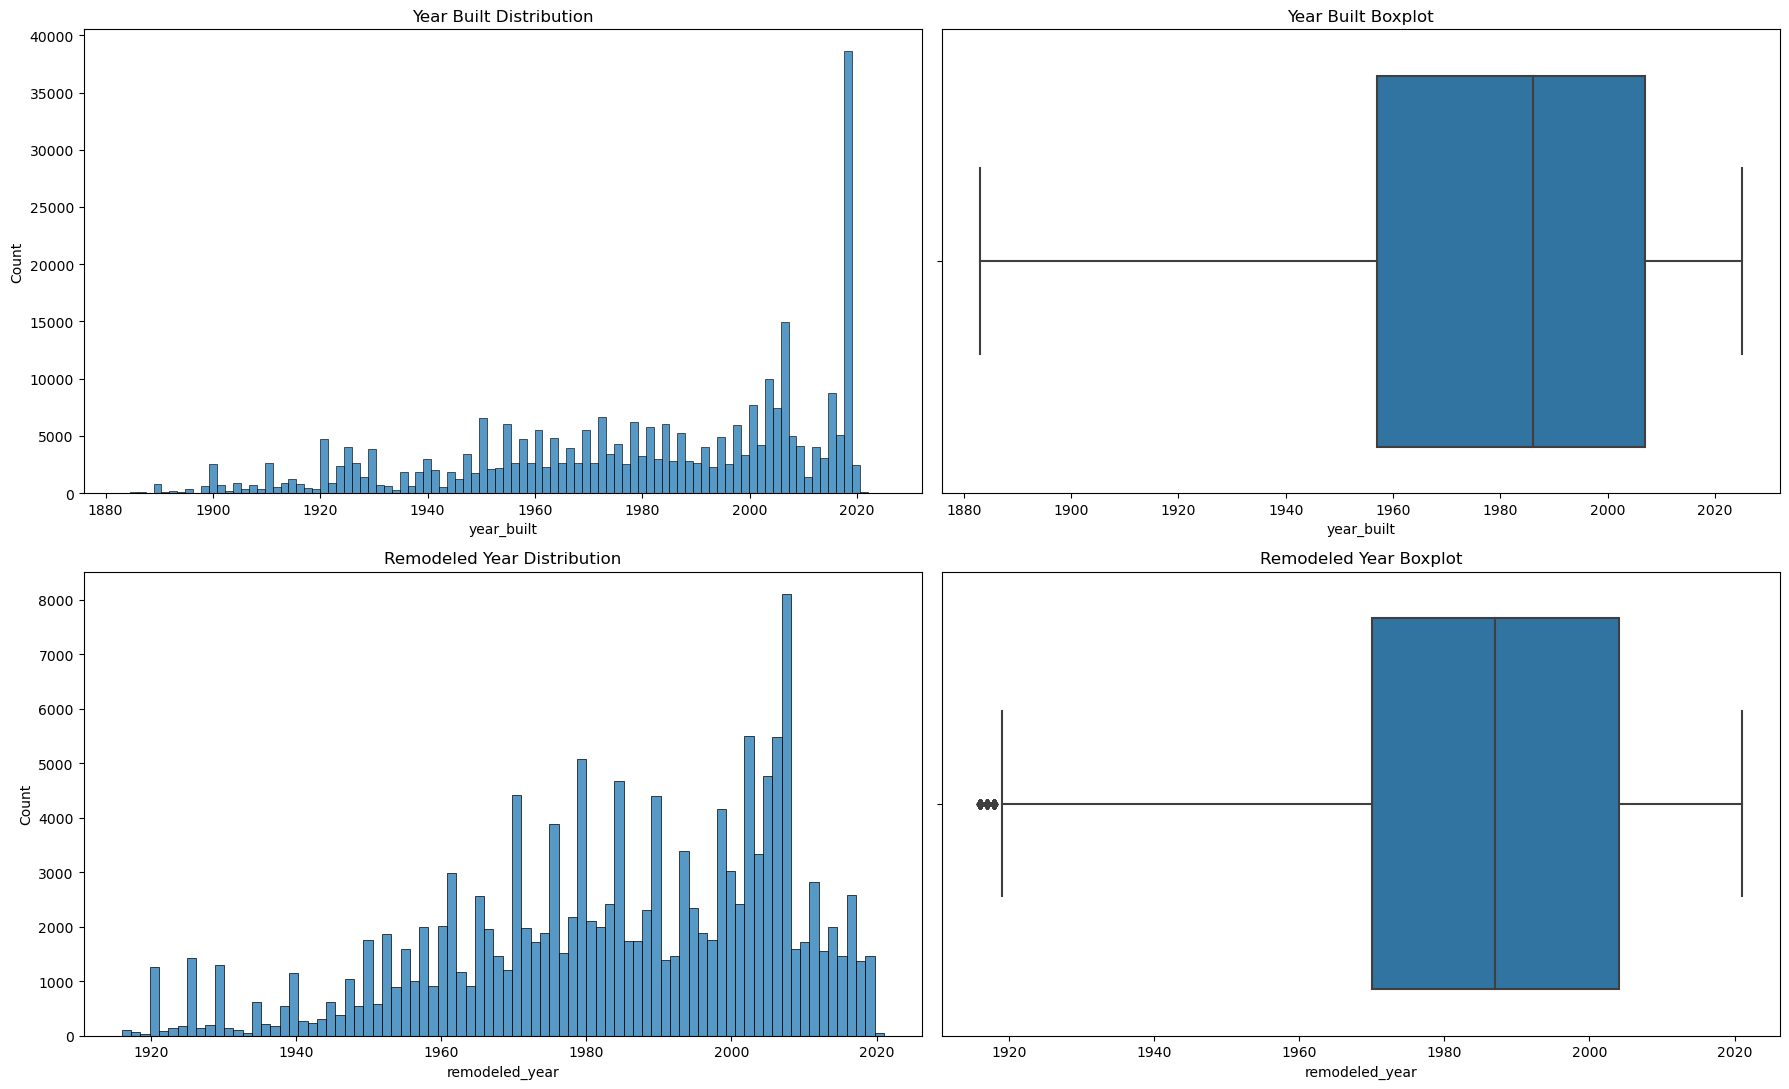

In [65]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(18, 11))

# визуализация 'year_built'
histplot = sns.histplot(data=cleaned, x='year_built', ax=axes[0, 0])
histplot.set_title('Year Built Distribution')
boxplot = sns.boxplot(data=cleaned, x='year_built', ax=axes[0, 1])
boxplot.set_title('Year Built Boxplot')

# визуализация 'remodeled_year'
histplot = sns.histplot(data=log_cleaned, x='remodeled_year', ax=axes[1, 0])
histplot.set_title('Remodeled Year Distribution')
boxplot = sns.boxplot(data=log_cleaned, x='remodeled_year', ax=axes[1, 1])
boxplot.set_title('Remodeled Year Boxplot')

plt.tight_layout()
plt.show()

Большинство данных представлено в период с 2000 по 2020 годы, также имеется информация об объектах XX и даже XIX века, при этом данных, начиная с 1900 года, сильно меньше. Также нельзя не обратить внимание на боксплот признака `remodeled_year`, который указывает на все значения меньше 1920 как выбросы, не вписывающиеся в межквартильный размах. В целом, данные согласуются с признаком `year_built`, поэтому считаем целесообразным удалить все данные ранее 1900 года: 

In [66]:
mask1 = data['year_built'] < 1900
mask2 = data['year_built'] > 2023

# объекты на удаление
year_outliers = data[mask1 | mask2].index

data.drop(year_outliers, inplace=True)

Вспомним визуализацию признака `remodeled_year` и удалим все данные, не вошедшие в диапазон межквартильного размаха:

In [67]:
mask3 = data['remodeled_year'] < 1920
remodeled_outliers = data[mask3].index
data.drop(remodeled_outliers, inplace=True)

Теперь поработаем с признаком `acres` - размером земельного участка. Для начала посмотрим его распределение:

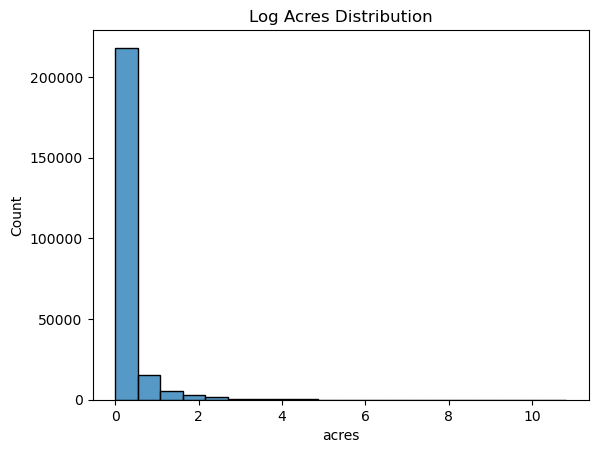

In [68]:
acres_histplot = sns.histplot(
    data = data, 
    x = np.log(data['acres'] + 1), 
    bins = 20
)
acres_histplot.set_title('Log Acres Distribution');

Выведем статистику по интересующему нас признаку:

In [69]:
acres_stat = data['acres'].describe()
acres_stat

count    245167.000000
mean          2.244071
std         148.237179
min           0.000000
25%           0.120000
50%           0.180000
75%           0.300000
max       49299.440000
Name: acres, dtype: float64

Все значения выше 3 акров встречаются относительно нечасто и выглядят скорее как выбросы, чем реальные данные. Однако вспомним об особенностях наших данных. Среди объектов недвижимости присутствуют ранчо, главный смысл приобретения которых - большой кусок земли для развития сельскохозяйственного бизнеса. Теперь всё встает на свои места. Для таких объектов внушительные размеры участков - скорее правило, чем исключение.  

Тем не менее, нам все равно нужно каким-либо образом очистить признак от потенциальных выбросов. В этот раз мы остановимся на методе сигм - он использует 3 стандартных отклонения от среднего и менее жестко фильтрует значения по сравнению с методом межквартильного размаха, основанном на перцентилях:

In [70]:
def outliers_z_score(data, feature, left=3, right=3, log_scale=False):
    """Использует метод z-отклонений (метод сигм) для фильтрации
    признака от выбросов
    
    Args:
        
        'data' - исходный датафрейм                
        
        'feature' - признак, по которому осуществляется
        поиск аномальных значений       
        
        'left' - левая нижняя граница  (3 по умолчанию)
        
        'right' - правая верхняя граница (3 по умолчанию)
        
        'log_scale' - параметр логарифмирования признака (False по умолчанию)
        
    Returns:
        
        'outliers' - потенциальные выбросы
        
        'cleaned' - очищенные строки датафрейма
    """
    if log_scale:
        x = np.log(data[feature] + 1)
    else:
        x = data[feature]
    
    mu = x.mean()
    sigma = x.std()
    
    lower_bound = mu - left * sigma
    upper_bound = mu + right * sigma
    
    outliers = data[(x < lower_bound) | (x > upper_bound)]
    cleaned = data[(x > lower_bound) & (x < upper_bound)]
    
    return outliers, cleaned

# применение функции к признаку
outliers, cleaned = outliers_z_score(data, 'acres', log_scale=True)

Посмотрим, с каких величин метод обозначает значения признака как выбросы:

In [71]:
print(f"Нижняя граница выбросов: {outliers['acres'].min()}")

Нижняя граница выбросов: 4.47


Удалим все строки с указанным значением и выше:

In [72]:
mask4 = data['acres'] >= 4.47
acres_outliers = data[mask4].index
data.drop(acres_outliers, inplace=True)

Теперь посмотрим на распределение признака `sqft`:

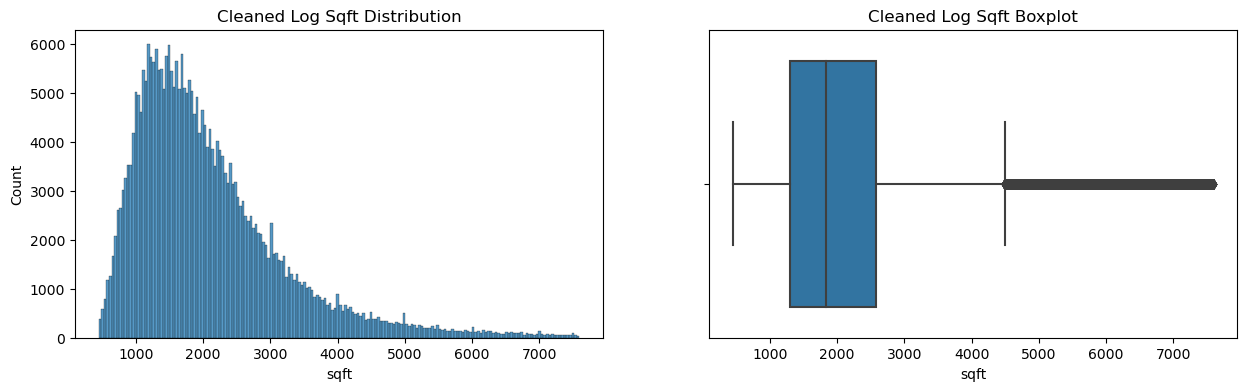

In [73]:
outliers_log, cleaned_log = outliers_iqr(data, 'sqft', log_scale=True)

# визуализация признака кв. футов
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))
histplot = sns.histplot(data=cleaned_log, x='sqft', ax=axes[0])
histplot.set_title('Cleaned Log Sqft Distribution')
boxplot = sns.boxplot(data=cleaned_log, x='sqft', ax=axes[1])
boxplot.set_title('Cleaned Log Sqft Boxplot');

Большинство объектов имеет среднюю площадь приблизительно в 1500 квадратных футов. Боксплот маркирует объекты площадью 4500 кв. футов как аномальные значения.  

Также в нашем признаке есть несуществующие площади, стремящиеся к нулю. Очевидно, такие размеры противоречат здравому смыслу. Из открытых источников известно, что самое маленькое жилье составляет 7 кв. метров (70 кв. футов) https://www.pravilamag.ru/articles/705945-razmer-ne-glavnoe-samye-malenkie-kvartiry-mira/. От этого и будем отталкиваться. Удалим все объекты, размер площади которых меньше 70 или больше 4500 кв. футов:

In [74]:
mask1 = data['sqft'] < 70
mask2 = data['sqft'] > 4500

# объекты на удаление
sqft_outliers = data[mask1 | mask2].index
data.drop(sqft_outliers, inplace=True)

Вооружившись знаниями о размерах самой маленькой недвижимости, вспомним, что ранее мы удаляли признак `price_sqft` - цену за 1 кв. фут объекта во избежание явления утечки данных. Типичная цена за 1 кв. фут недвижимости составляла `$125`. Путем нехитрых математических вычислений мы понимаем, что адекватная стоимость такого объекта должна быть не менее `$8750`. Однако в наших данных целевой признак содержит и меньшие значения:   

In [75]:
print(f"Мин. стоимость объекта недвижимости: $ {data['target'].min()}")

Мин. стоимость объекта недвижимости: $ 1.0


Не спорим, такие ситуации имеют место быть. Чаще всего такие дома продаются по символической цене на определенных условиях - по программам переселения, восстановление ветхих домов за счет средств будущего владельца etc. https://immigrant.today/usa/14559-kak-kupit-dom-v-amerike-za-1-dollar.htm. Однако такие значения не очень хорошо будут сказываться на точности прогнозной модели и коррелировать с типичными ценами на оставшиеся дома. Поэтому избавимся от таких объектов:

In [76]:
mask = data['target'] < 8750
target_outliers = data[mask].index
data.drop(target_outliers, inplace=True)

Воспользуемся методом z-отклонений для очистки признака `beds`:

In [77]:
outliers, cleaned = outliers_z_score(data, 'beds', log_scale=True)
print(f"Макс. допустимое кол-во спален: {cleaned['beds'].max()}")

Макс. допустимое кол-во спален: 8.0


Если поразмыслить, то дом с 9 спальными комнатами и выше - это огромные апартаменты или целый дворец. Такой роскошью не каждая президентская резиденция может похвастаться.

In [78]:
mask = data['beds'] > 8
beds_outliers = data[mask].index
data.drop(beds_outliers, inplace=True)

На очереди - признак количества ванных комнат:

In [79]:
outliers, cleaned = outliers_z_score(data, 'baths', log_scale=True)
print(f"Макс. допустимое кол-во ванных комнат: {cleaned['baths'].max()}")

Макс. допустимое кол-во ванных комнат: 7.0


Конечно, в дополнение к методу мы могли бы построить визуализацию его работы, однако это не будет репрезентативно в силу того, что мы еще не до конца избавились от выбросов в признаке. Поэтому, как и раньше отфильтруем объекты по верхней границе и оставим только данные, у которых встречается до 7 полноценных ванных комнат включительно:

In [80]:
mask = data['baths'] > 7
baths_outliers = data[mask].index
data.drop(baths_outliers, inplace=True)

Далее очистим признак средней дистанции до школы:

In [81]:
outliers, cleaned = outliers_z_score(data, 'avg_distance_school', log_scale=True)
print(f"Макс. допустимое расстояние: {cleaned['avg_distance_school'].max()} miles")

Макс. допустимое расстояние: 16.56 miles


В американской сельской местности такие дистанции до ближайших населенных пунктов - обычное явление, поскольку практически каждая семья имеет несколько машин. 

In [82]:
mask = data['avg_distance_school'] > 16.56
distance_outliers = data[mask].index
data.drop(distance_outliers, inplace=True)

У нас остался последний количественный признак `stories` - количество этажей в здании. Посмотрим на его описательные характеристики:

In [83]:
stories_stat = data['stories'].describe()
stories_stat

count    204964.000000
mean          1.859379
std           4.294012
min           0.000000
25%           1.000000
50%           1.000000
75%           2.000000
max        1120.000000
Name: stories, dtype: float64

Большинство американских домов являются одноэтажными или двухэтажными. Запредельное значение в 1120 этажей - это очевидный выброс.  

В данном случае ни один их двух ранее использованных методов не подходит, поэтому воспользуемся здравым смыслом. Общеизвестный факт, что в США сконцентрировано большое количество небоскребов. Давайте вспомним, что в наших данных встречались такие типы недвижимости как `High-Rise`, `Mid-Rise`, `Penthouse`. В сельской местности земля более доступна, чем в городской черте, соответственно дома за городом редко бывают выше двух этажей. Напротив, в городах и крупных населенных пунктах плотность застройки максимально высокая, что ведет к увеличению высоты зданий. Таким образом, зная обо всем этом, высотки и небоскребы до 100 этажей уже не кажутся аномальными значениями.  

Обратим также внимание, что в данных находятся объекты с нулевыми значениями. Очевидно, что это выбросы, поэтому отфильтруем объекты и от них:

In [84]:
mask1 = data['stories'] < 1
mask2 = data['stories'] >= 100

# объекты на удаление
stories_outliers = data[mask1 | mask2].index
data.drop(stories_outliers, inplace=True)

Также давайте избавимся от признака - идентификатора, поскольку он нам больше не потребуется:

In [85]:
data = data.drop('MlsId', axis=1)

Осталось только заполнить пропуски в данных. Выведем информацию по каждому из признаков:

In [86]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 296534 entries, 0 to 377184
Data columns (total 20 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   baths                227363 non-null  float64
 1   city                 296516 non-null  object 
 2   sqft                 276804 non-null  float64
 3   zipcode              296533 non-null  float64
 4   state                296534 non-null  object 
 5   stories              194674 non-null  float64
 6   pool                 296534 non-null  object 
 7   target               296534 non-null  float64
 8   status               296534 non-null  object 
 9   type                 266604 non-null  object 
 10  beds                 223894 non-null  float64
 11  year_built           264605 non-null  float64
 12  remodeled_year       126394 non-null  float64
 13  heating              296534 non-null  object 
 14  parking              296534 non-null  object 
 15  is_garage        

Заполним `type`, `baths`, `stories` и `beds` модальным значением признаков:

In [87]:
# инициализация модальных значений
mode_type = data['type'].mode()[0]
mode_baths = data['baths'].mode()[0]
mode_stories = data['stories'].mode()[0]
mode_beds = data['beds'].mode()[0]

# заполнение пропусков
data['type'] = data['type'].fillna(mode_type)
data['baths'] = data['baths'].fillna(mode_baths)
data['stories'] = data['stories'].fillna(mode_stories)
data['beds'] = data['beds'].fillna(mode_beds)

С некоторыми признаками ситуация не такая простая. В процессе обработки `year_built` и `remodeled_year` получилось так, что для некоторых объектов год модернизации здания оказался меньше года постройки. Такая ситуация противоречит здравому смыслу, ведь еще не построенный объект не может проходить реставрацию (если только его специально кто-то не телепортировал во времени -_-).  

Посмотрим, сколько таких объектов на данный момент содержится в данных:

In [88]:
print(f"Кол-во выбросов: {len(data[data['remodeled_year'] < data['year_built']])}")

Кол-во выбросов: 2154


Удалим такие объекты как аномальные:

In [89]:
years_outliers = data[data['remodeled_year'] < data['year_built']].index
data.drop(years_outliers, axis=0, inplace=True)

Оба признака содержат отсутствующие значения, причем признак `remodeled_year` наименее заполнен:

In [90]:
rem_missing = data['remodeled_year'].isnull().sum()
total = data.shape[0]
rem_missing_percent = (rem_missing / total) * 100

print(f"Кол-во пропущенных значений признака `remodeled_year`: \
{rem_missing_percent:.1f} %")

Кол-во пропущенных значений признака `remodeled_year`: 57.8 %


Увы, но восстанавливать данные медианным значением - не самый подходящий метод, к тому же есть риск внести ненужный дополнительный шум в данные. Признак отфильтрован от аномальных значений, поэтому воспользуемся уже проверенным способом - превратим его в бинарный категориальный, где наличие года будет свидетельствовать о том, что реновация проводилась, отсутствие значения - объект не подвергался реставрации:

In [91]:
data['remodeled_year'] = data['remodeled_year'].fillna('no').apply(
    lambda x: 'yes' if x != 'no' else x)

Восстановим пропущенные данные в `year_built`, заполнив год постройки модальным значением признака:

In [92]:
mode_year_built = data['year_built'].mode()[0]
data['year_built'] = data['year_built'].fillna(mode_year_built)

Признак количества акров также содержит в себе пропущенные значения. Будем считать, что для таких объектов недвижимости земельный участок не предусмотрен, поэтому заполним признак нулевыми значениями:

In [93]:
data['acres'] = data['acres'].fillna(0)

Также у нас остались пропуски в признаках `avg_rating_school` и `avg_distance_school`. Такие объекты составляют незначительную часть датасета, поэтому во избежание лишних искажений в данных считаем целесообразным удалить их:

In [94]:
mask1 = data['avg_rating_school'].isnull()
mask2 = data['avg_distance_school'].isnull()

# объекты на удаление
outliers = data[mask1 | mask2].index
data.drop(outliers, inplace=True)

Строки, по которым не удалось восстановить количество квадратных футов объекта для нас также бесполезны:

In [95]:
sqft_outliers = data[data['sqft'].isnull()].index
data.drop(sqft_outliers, axis=0, inplace=True)

Избавимся также от пропусков в признаках `city` и `zipcode`:

In [96]:
# удаляем пустые строки по признаку 'zipcode'
zip_outliers = data[data['zipcode'].isnull()].index
data.drop(zip_outliers, axis=0, inplace=True)

# удаляем пустые строки по признаку 'city'
city_outliers = data[data['city'].isnull()].index
data.drop(city_outliers, axis=0, inplace=True)

Дадим признакам `year_built` и `remodeled_year` более подходящие названия:

In [97]:
data.rename(
    columns={'year_built': 'built', 'remodeled_year': 'remodeled'}, 
    inplace=True
)

Выведем статистику по полученным признакам:

In [98]:
data.describe()

,baths,sqft,zipcode,stories,target,beds,built,acres,avg_rating_school,avg_distance_school,has_pk
count,271765.000000,271765.000000,271765.000000,271765.000000,2.717650e+05,271765.000000,271765.000000,271765.000000,271765.000000,271765.000000,271765.000000
mean,2.406487,1930.030600,53062.547944,1.654198,4.714844e+05,3.174390,1983.544014,0.204752,5.135962,2.697997,0.771118
std,0.867778,853.743361,26610.632253,2.345178,6.852514e+05,0.917078,31.639153,0.392983,1.908339,2.774823,0.420114
min,0.000000,72.000000,1104.000000,1.000000,8.900000e+03,0.000000,1900.000000,0.000000,1.000000,0.020000,0.000000
25%,2.000000,1274.000000,33062.000000,1.000000,2.099000e+05,3.000000,1960.000000,0.000000,3.700000,1.040000,1.000000
50%,2.000000,1778.000000,37377.000000,1.000000,3.200000e+05,3.000000,1990.000000,0.130000,5.000000,1.710000,1.000000
75%,3.000000,2440.000000,78045.000000,2.000000,5.199000e+05,4.000000,2012.000000,0.220000,6.500000,3.060000,1.000000
max,7.000000,4500.000000,331446.000000,96.000000,5.000000e+07,8.000000,2022.000000,4.460000,10.000000,16.560000,1.000000


Данные пришли в норму, теперь можно продолжать работу с ними. Сбросим индексы датасета и переназначим заново:

In [99]:
data.reset_index(drop=True, inplace=True)

Выстроим признаки в удобном для нас порядке и сохраним очищенный датасет в новый файл:

In [100]:
columns_order = ['status', 'type', 'zipcode', 'state', 'city', 'sqft', 'stories', 'baths', 
                 'beds', 'heating', 'parking', 'is_garage', 
                 'pool', 'acres', 'avg_rating_school', 'avg_distance_school', 
                 'has_pk', 'built', 'remodeled', 'target']

# переназначение порядка признаков
data = data.reindex(columns=columns_order)

# сохранение датасета
data.to_csv("data/realty_data.csv", index=False)